In [31]:
import base64
import json
from azure.ai.ml import MLClient, Input
from azure.ai.ml.entities import ManagedOnlineEndpoint, ManagedOnlineDeployment, Model, CodeConfiguration, OnlineRequestSettings
#from azure.ai.ml.entities import ManagedOnlineEndpoint, ManagedOnlineDeployment, Model, Environment, JobService, Data, CodeConfiguration, OnlineRequestSettings, AmlCompute

from azure.ai.ml.constants import AssetTypes
from azure.identity import DefaultAzureCredential

In [2]:
# AzureML Workspace
subscription_id = 'b7d41fc8-d35d-41db-92ed-1f7f1d32d4d9'
resource_group = 'ams-monai-seg-reg-rg'
workspace = 'ams-monai-seg-reg-wg'

In [27]:
ml_client = MLClient(DefaultAzureCredential(), subscription_id, resource_group, workspace)

In [30]:
# Deployment
online_endpoint_name = "SRG-endpoint"
registered_model_name = 'SRG'
deployment_name = 'red'

In [12]:
# Let's pick the latest version of the model
latest_model_version = max([int(m.version) for m in ml_client.models.list(name= registered_model_name)])

print(f'Latest version of {registered_model_name} found: {latest_model_version}')

Latest version of SRG found: 1


In [6]:
# model_name = 'sklearn-diabetes'
# model_local_path = "sklearn-diabetes/model"
# model = ml_client.models.create_or_update(
#         Model(name=model_name, path=model_local_path, type=AssetTypes.MLFLOW_MODEL)
# )

model = ml_client.models.get(name=registered_model_name, version=1)


In [15]:
#endpoint_name = "SRG-endpoint" + datetime.datetime.now().strftime("%m%d%H%M%f")
endpoint_name = online_endpoint_name

endpoint = ManagedOnlineEndpoint(
    name=endpoint_name,
    description="An online endpoint to generate predictions for the diabetes dataset",
    auth_mode="key",
    tags={"foo": "bar"},
)

In [16]:
ml_client.begin_create_or_update(endpoint)

In [32]:
blue_deployment = ManagedOnlineDeployment(
    name=deployment_name,
    endpoint_name=online_endpoint_name,
    model=model,
    environment="srg-env:2",
    code_configuration=CodeConfiguration(
        code="./src",
        scoring_script="score.py"
    ),
    instance_type="Standard_NC4as_T4_v3",
    instance_count=1,
    request_settings= OnlineRequestSettings(request_timeout_ms = 90000),
)

In [33]:
deployment = ml_client.begin_create_or_update(blue_deployment)

Check: endpoint SRG-endpoint exists
data_collector is not a known attribute of class <class 'azure.ai.ml._restclient.v2022_02_01_preview.models._models_py3.ManagedOnlineDeployment'> and will be ignored


...............................

In [34]:
endpoint = ml_client.online_endpoints.get(online_endpoint_name)
print(f"Endpoint {endpoint.name} provisioning state: {endpoint.provisioning_state}")

Endpoint srg-endpoint provisioning state: Succeeded


In [ ]:
ml_client.online_deployments.get_logs(
    name=deployment_name, endpoint_name=online_endpoint_name, lines=50
)

In [35]:
# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

{'red': 0, 'blue': 0}
https://srg-endpoint.westeurope.inference.ml.azure.com/score


In [ ]:
# blue deployment takes 100 traffic
endpoint.traffic = {"blue": 100}
ml_client.online_endpoints.begin_create_or_update(endpoint).result()

In [23]:
# Visualization and validation sample
sample_image = './samples-2021/BraTS2021_00402/BraTS2021_00402_flair.nii.gz' # pick flair modality
sample_image_t1 = './samples-2021/BraTS2021_00402/BraTS2021_00402_t1.nii.gz'
sample_image_t1ce = './samples-2021/BraTS2021_00402/BraTS2021_00402_t1ce.nii.gz'
sample_image_t2 = './samples-2021/BraTS2021_00402/BraTS2021_00402_t2.nii.gz'
sample_label = './samples-2021/BraTS2021_00402/BraTS2021_00402_seg.nii.gz'

In [25]:
# Encode input images for JSON request file
with open(sample_image, "rb") as image_file:
    flair_encoded = base64.b64encode(image_file.read()).decode('utf-8')

with open(sample_image_t1, "rb") as image_file:
    t1_encoded = base64.b64encode(image_file.read()).decode('utf-8')

with open(sample_image_t1ce, "rb") as image_file:
    t1ce_encoded = base64.b64encode(image_file.read()).decode('utf-8')

with open(sample_image_t2, "rb") as image_file:
    t2_encoded = base64.b64encode(image_file.read()).decode('utf-8')

request_data = {
    "data": [{"flair": flair_encoded, "t1": t1_encoded, 
              "t1ce": t1ce_encoded, "t2": t2_encoded
             }]
}

# Write the JSON request data to a file
with open("request-1.json", "w") as outfile:
    json.dump(request_data, outfile)

In [36]:
response = ml_client.online_endpoints.invoke(
    endpoint_name= online_endpoint_name,
    deployment_name= deployment_name,
    request_timeout_ms=90000,
    request_file="./request-1.json",
)


In [37]:
import numpy as np
import matplotlib.pyplot as plt


# convert response to numpy array with dimensions channel, height, width, slice
json_response = json.loads(response)
pred_vol = np.array(json_response)

In [38]:
import torch
from monai.apps import DecathlonDataset
from monai.data import DataLoader, Dataset
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Orientationd, Spacingd, NormalizeIntensityd, MapTransform
from monai.visualize.utils import blend_images

class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats 2021 classes:
    label 1 necrotic tumor core (NCR)
    label 2 peritumoral edematous/invaded tissue 
    label 3 is not used in the new dataset version
    label 4 GD-enhancing tumor 
    The possible classes are:
      TC (Tumor core): merge labels 1 and 4
      WT (Whole tumor): merge labels 1,2 and 4
      ET (Enhancing tumor): label 4

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 1 and label 4 to construct TC
            result.append(torch.logical_or(d[key] == 1, d[key] == 4))
            # merge labels 1, 2 and 4 to construct WT
            result.append(
                torch.logical_or(
                    torch.logical_or(d[key] == 1, d[key] == 2), d[key] == 4
                )
            )
            # label 4 is ET
            result.append(d[key] == 4)
            d[key] = torch.stack(result, axis=0).float()
        return d

val_transform = Compose(
[
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys="image"),
    EnsureTyped(keys=["image", "label"]),
    ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest"),
    ),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
])

data_list = [{'image': sample_image, 'label': sample_label}]
val_ds = Dataset(data=data_list, transform=val_transform)

img_vol = val_ds[0]["image"].numpy()
seg_vol = val_ds[0]["label"].numpy()

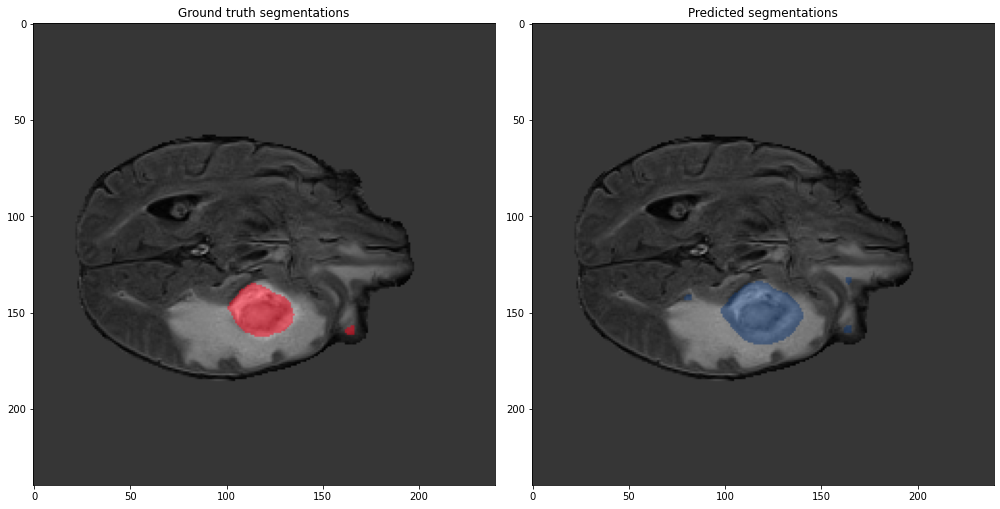

In [39]:
from ipywidgets import interact

def show_slice(slice_index=60):

    img = np.expand_dims(img_vol[0,:,:,slice_index], 0) # images
    true_seg = np.expand_dims(seg_vol[0,:,:,slice_index], 0) # annotated ground truth labels
    pred_seg = np.expand_dims(pred_vol[0,:,:,slice_index], 0)  # predicted labels
    
    blend = blend_images(img, true_seg, cmap='hsv')
    over_true = np.transpose(blend, (1,2,0))
    blend = blend_images(img, pred_seg, cmap='Blues')
    over_pred = np.transpose(blend, (1,2,0))
    
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 7))

    ax1.imshow(over_true)
    ax1.set_title('Ground truth segmentations')
    ax2.imshow(over_pred)
    ax2.set_title('Predicted segmentations')
    
    plt.tight_layout()
    plt.show()

# Use the interact function to create a slider for the slice index
_ = interact(show_slice, slice_index=(0, img_vol.shape[-1]-1))